C:\Users\pdeep\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9357010313727182
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     20228
           1       0.89      0.56      0.69      2945

    accuracy                           0.94     23173
   macro avg       0.92      0.78      0.83     23173
weighted avg       0.93      0.94      0.93     23173

AUC: 0.9531471278360477


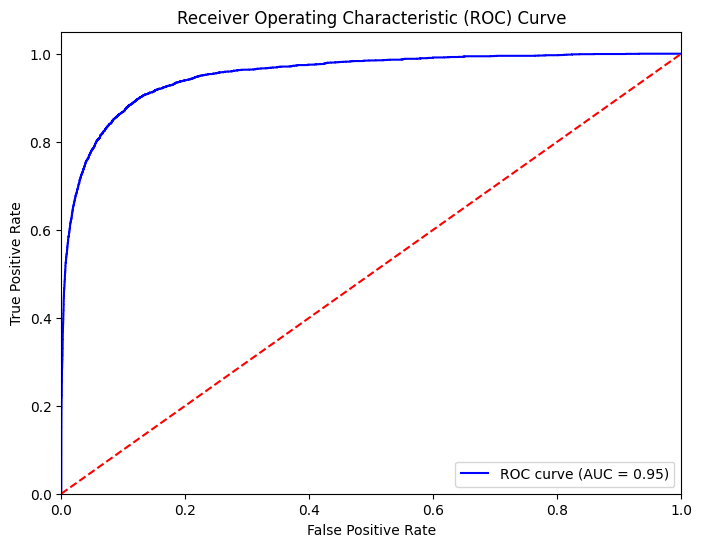

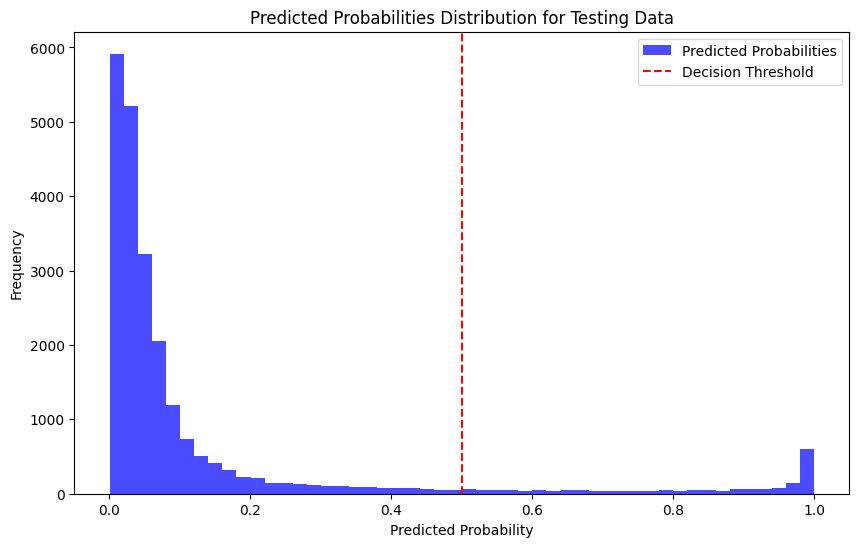

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('GSoc CALEL Test-20240320T121822Z-001/GSoc CALEL Test/cyberbullying/aggression_parsed_dataset.csv')

# Data preprocessing - Text cleaning
def clean_text(text):
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply text cleaning function to 'Text' column
df['clean_text'] = df['Text'].apply(clean_text)

# Split the data into training and testing sets
X = df['clean_text'].values
y = df['oh_label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize Logistic Regression model
logreg_model = LogisticRegression()

# Train the model
logreg_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred = logreg_model.predict(X_test_tfidf)
y_pred_proba = logreg_model.predict_proba(X_test_tfidf)[:, 1]  # Predicted probabilities for positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)
print("AUC:", auc)

# Plotting the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300)
plt.show()

# Plotting predicted probabilities for testing on withheld data
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba, bins=50, alpha=0.7, color='b', label='Predicted Probabilities')
plt.axvline(x=0.5, color='r', linestyle='--', label='Decision Threshold')
plt.title('Predicted Probabilities Distribution for Testing Data')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('predicted_probabilities_plot.png', dpi=300)
plt.show()

# Plotting the top features
feature_coeffs = logreg_model.coef_[0]
feature_names = tfidf_vectorizer.get_feature_names()
feature_importance = dict(zip(feature_names, feature_coeffs))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
top_n = 10
features = [feature[0] for feature in sorted_features[:top_n]]
coefficients = [feature[1] for feature in sorted_features[:top_n]]

plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients, y=features)
plt.title('Top 10 Features Contributing to Cyberbullying Classification')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.savefig('top_features_plot.png', dpi=300)
plt.show()

# Plotting misclassified instances
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]
for idx in misclassified_indices:
    instance_feature_vector = X_test_tfidf[idx].reshape(1, -1)
    predicted_proba = logreg_model.predict_proba(instance_feature_vector)
    print(f"Instance: {X_test[idx]}")
    print(f"True Label: {y_test[idx]}, Predicted Label: {y_pred[idx]}")
    print(f"Predicted Probabilities: {predicted_proba}")
    print("---------")
